<h1><center><font color=darkcyan>  DEEP NEURAL NETWORKS </font></center></h1>

<h2><center><font color=darkorange> Travaux Pratiques</font></center></h2>

<lu>
    <li><font color=darkblue> SOPGOUI MBEUKAM Lionel</font></li>
</lu>
<hr>

In [1]:
import numpy as np
from datetime import datetime
import scipy.io
from numpy.random import uniform
import matplotlib.pyplot as plt
from time import time
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data import DataLoader, Sampler
import torchvision
%matplotlib notebook
from scipy.io import loadmat
import warnings
warnings.filterwarnings("ignore")

## _Construction d'un RBM et Test sur Binary AlphaDigits_

In [2]:
def sigmoide(x):    
    return 1 / (1 + np.exp(x))

In [3]:
class RBM:
    # Lire la base Binary Alpha Digits
    def read_alpha_digits(self, file, i):
        x = loadmat("binaryalphadigs.mat")
        datas = x['dat']
        data = np.array([[im.ravel() for im in datas[i]] for i in range(len(datas))])
        data = data.reshape(-1,320).T
        labels = x['classlabels'][0].T
        label = np.array([[labels[i][0] for im in data[i]] for i in range(len(labels))])
        label = label.reshape(-1,1404)
        exemple = np.array([im.ravel() for im in datas[i]]).T

        return np.array(data), np.array(label), exemple

    #Initialiser le RBM p for visible, q for hidden
    def init_RBM(self,p,q,batch_size,learning_rate,epochs):
        self.p = p
        self.q = q
        self.a = np.zeros((q,1))
        self.b = np.zeros((p,1))
        self.W = np.random.normal(0,0.1,(p,q))
        self.learning_rate = learning_rate / batch_size
        self.batch_size = batch_size
        self.epochs = epochs 
        return self
    
    def entree_sortie_RBM(self, entree):
        #returns a (hidden_size,batch_size) vector
        exp = (self.W.T @ entree) + self.a
        return 1 / (1 + np.exp(-exp))
    
    def sortie_entree_RBM(self, sortie):
        #returns a (visible_size,batch_size) vector
        exp = (self.W @ sortie) + self.b
        return 1 / (1 + np.exp(-exp))
    
    def echantillonnage(self,batch):
        batch_size = batch.shape[1]
        h_0 = np.random.binomial(1,self.entree_sortie_RBM(batch))
        v_1 = np.random.binomial(1,self.sortie_entree_RBM(h_0))
        h_1 = np.random.binomial(1,self.entree_sortie_RBM(v_1))
        return v_1,h_1
    
    def descente_gradient(self,batch):
        v_0 = batch
        v_1,h_1 = self.echantillonnage(batch)
        pr_h_v0 = self.entree_sortie_RBM(v_0)
        dW = batch.T[...,None]*pr_h_v0.T[:,None,:] - v_1.T[...,None]*h_1.T[:,None,:]
        da = pr_h_v0 - h_1
        db = v_0 - v_1
        return [dW,db,da]
    
    def erreur(self,donnees):
        h = self.entree_sortie_RBM(donnees)
        v = self.sortie_entree_RBM(h)
        return np.linalg.norm(v - donnees) / donnees.shape[1]
    
    def train_RBM(self,donnees):
        print("== > TRAIN RBM <==")
        for i in range(self.epochs):
            #print(f"epoch {i+1} / {self.epochs} : EQM {self.erreur(donnees)}")
            #sample indexes for batch gradient
            indexes = np.random.permutation(donnees.shape[1])
            batches = [donnees[:,indexes[i:i+self.batch_size]] 
                       for i in range(0,len(indexes),self.batch_size)]
            for batch in batches: 
                grad = self.descente_gradient(batch)
                dW = np.sum(grad[0],axis = 0)
                db = np.sum(grad[1],axis = 1).reshape(-1,1)
                da = np.sum(grad[2],axis = 1).reshape(-1,1)
                #update step
                self.W += self.learning_rate * dW
                self.b += self.learning_rate * db
                self.a += self.learning_rate * da
        print("== > FIN TRAIN RBM <==")
        return self
    
    
    def generer_image_RBM(self,p, nb_img, nb_itergibbs):
        v = np.random.binomial(1,0.5,(p, nb_img))
        for i in range(nb_itergibbs):
            h = np.random.binomial(1,self.entree_sortie_RBM(v))
            v = np.random.binomial(1,self.sortie_entree_RBM(h))
        return v.T

In [4]:
def principal_RBM_alpha():
    rbm = RBM()
    rbm = rbm.init_RBM(320,200,10,0.1,100)
    data, label, exemple = rbm.read_alpha_digits("binaryalphadigs.mat", 11)
    plt.figure()
    i = 30
    rbm = rbm.train_RBM(data[:,39*i:39*(i+1)])
    gen = rbm.generer_image_RBM(320,4, 2000)
    plt.figure()
    #plt.imshow(gen[0].reshape(20,16), cmap = 'summer')
    #plt.imshow(data[:,1].reshape(20,16), cmap = 'gray')
    return rbm, data, label, gen
rbm, data, label, gen = principal_RBM_alpha()

== > TRAIN RBM <==
== > FIN TRAIN RBM <==


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

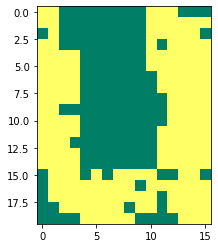

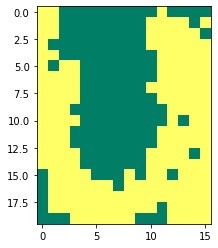

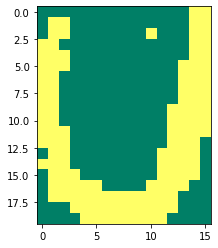

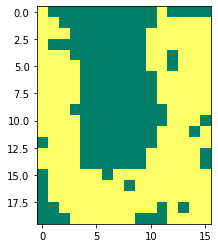

In [5]:
for i in range(4):
    plt.figure()
    plt.imshow(gen[i].reshape(20,16), cmap = 'summer')

## _Construction d'un DBM et Test sur Binary AlphaDigits_

In [6]:
class DBN:
    # Lire la base Binary Alpha Digits

    #Initialiser le RBM
    def init_DBN(self, layers_size, batch_size, learning_rate, epochs):
        #n est le nombre de neuronnes par couches
        self.L = len(layers_size)
        
        self.rbms = []
        for i in range(0,self.L - 1):
            rbm = RBM()
            self.rbms.append(rbm.init_RBM(layers_size[i],layers_size[i+1],batch_size,learning_rate,epochs))
        return self
    
    #Entrainement du DNN
    def train_DBN(self, donnees):
        x = np.copy(donnees).T
        i = 1
        print("== > TRAIN DBN <==")
        for rbm in self.rbms:
            #print(f" ==>> Couche n° {i}")
            print(rbm.a.shape, rbm.W.shape, rbm.b.shape)
            rbm = rbm.train_RBM(x)
            x = rbm.entree_sortie_RBM(x)
            i = i+1
        print("== > FIN <==")
        return self
    
    def generer_image_DBN(self,p, nb_img, nb_itergibbs):
        v = np.random.binomial(1,0.5,(p, nb_img))
        for i in range(nb_itergibbs):
            for rbm in self.rbms:
                v = np.random.binomial(1,rbm.entree_sortie_RBM(v))
            for rbm in self.rbms[::-1]:
                v = np.random.binomial(1,rbm.sortie_entree_RBM(v))
        return v.T

== > TRAIN DBN <==
(300, 1) (320, 300) (320, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
(200, 1) (300, 200) (300, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
(100, 1) (200, 100) (200, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
(36, 1) (100, 36) (100, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
== > FIN <==


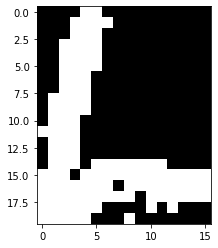

In [7]:
def principal_DBN_alpha():
    dbn = DBN()
    #data, label = dbn.read_alpha_digits("binaryalphadigs.mat")
    dbn = dbn.init_DBN([320,300,200,100, 36], 10, 0.1, 100)
    i = 21
    dbn = dbn.train_DBN(data[:,39*i:39*(i+1)].T)
    gen = dbn.generer_image_DBN(320, 4, 2000)
    plt.figure()
    plt.imshow(gen[1].reshape(20,16), cmap = 'gray')
    #plt.imshow(data[:,1].reshape(20,16), cmap = 'gray')
    return dbn, gen

dbn, gen = principal_DBN_alpha()

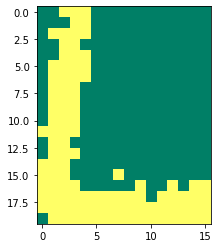

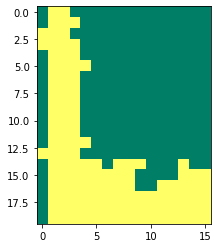

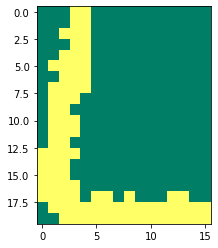

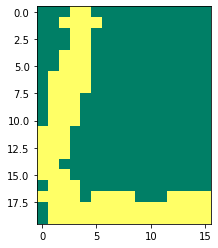

In [8]:
for i in range(4):
    plt.figure()
    plt.imshow(gen[i].reshape(20,16), cmap = 'summer')

## _Construction d'un DNN et Test sur MINST_

_Téléchargement et Chargement des données d'apprentissage et de test_

In [10]:
dl = DataLoader(torchvision.datasets.MNIST('pfe', train=True, download=True),batch_size=30, shuffle=False)

In [11]:
dltest = DataLoader(torchvision.datasets.MNIST('pfe', train=False, download=True),batch_size=30, shuffle=False)

In [12]:
X_train = dl.dataset.data.reshape(-1,784).float()
y_train = dl.dataset.targets

X_test = dltest.dataset.data.reshape(-1,784).float()
y_test = dltest.dataset.targets

_Il s'agit ici de convertir le label y par un vecteur de taille 10 où toutes les valeurs sont à 0 sauf la valeur à la position y qui vaut 1_

In [13]:
train_y = []
for y in y_train:
    vector = np.zeros((10,1))
    vector[y] = 1
    train_y.append(vector)
    
train_y = np.hstack(train_y)

test_y = []
for y in y_test:
    vector = np.zeros((10,1))
    vector[y] = 1
    test_y.append(vector)   
test_y = np.hstack(test_y)

X_train = X_train.T.numpy()
X_test  = X_test.T.numpy()

In [14]:
X_train = (X_train > 0.5)
test  = (X_test > 0.5)

In [22]:
class DNN: 
    def __init__(self, couches_size, batch_size, lr, pre_train = False):
        self.couches_size= couches_size
        self.L = len(couches_size) - 1
        self.W  = {i : np.random.normal(0,0.1,(next_couche,couche)) for (i,couche,next_couche) in
                          zip(range(1,self.L+1),couches_size, couches_size[1:])}
        self.biais = {i : np.zeros((couche,1)) 
                           for (i,couche) in zip(range(1,self.L+1),couches_size[1:])}
        self.batch_size = batch_size
        self.pre_train  = pre_train
        self.lr = lr
        
    def calcul_softmax(self, x):
        exp_x = np.exp(x)
        return np.exp(x) / np.sum(exp_x, axis = 0)
    
    def sigmoide(self, x):
        exp = np.exp(-1*x)
        return 1 / (1 + exp)
    
    def cross_entropy(self, entrees, y):
        outputs     = self.entree_sortie_reseau(entrees)[self.L]
        log_outputs = np.log(outputs)
        return np.sum(np.sum(y * log_outputs,axis = 0))
                  
    def entree_sortie_reseau(self,x):
        couches = {i : [] for i in range(self.L + 1)}
        couches[0] = x
        for l in range(1,self.L):
            couches[l] = self.sigmoide(self.W[l] @ couches[l-1] + self.biais[l]) #Correspond à entree_sortie_RBM
        
        couches[self.L] = self.calcul_softmax(self.W[self.L] @ couches[self.L - 1] + self.biais[self.L])
        return couches
        
    def retropropagation(self,x_batch,y_batch):
        couches = self.entree_sortie_reseau(x_batch)
        c = couches[self.L] - y_batch
        dW = {self.L :  c @ couches[self.L - 1].T}
        grad_biais = {self.L :  np.sum(c,axis = 1).reshape(-1,1)}

        for l in range(self.L - 1, 0 ,-1):
            c = (self.W[l+1].T @ c) * couches[l] * (1 - couches[l])
            dW[l] = c @ couches[l-1].T
            grad_biais[l]  = np.sum(c, axis = 1).reshape(-1,1)
        for l in range(1,self.L+1):
            self.W[l] = self.W[l] - (self.lr/self.batch_size) * dW[l]
            self.biais[l]  = self.biais[l] - (self.lr/self.batch_size) * grad_biais[l]
            
    def train_DNN(self,X_train, y_train, X_test, y_test,epochs):
        if self.pre_train == True: 
            print("Phase de Pré-entrainement !")
            dbn = DBN()
            dbn = dbn.init_DBN(self.couches_size,
                      batch_size = 100,
                      learning_rate = self.lr,
                      epochs = 200)
            dbn = dbn.train_DBN(X_train.T)
            for i,rbm in enumerate(dbn.rbms):
                self.W[i+1],self.biais[i+1] = rbm.W.T, rbm.a
        
        print("Phase d'Entrainement !")
        for i in range(epochs):
            indexes = np.random.permutation(X_train.shape[1])
            batches = [(X_train.T[indexes[i:i+self.batch_size]].T,y_train.T[indexes[i:i+self.batch_size]].T)
                       for i in range(0,len(indexes),self.batch_size)]
            for batch in batches: 
                self.retropropagation(batch[0],batch[1])
            print(f"epoch n° {i+1} / {epochs} | cross_entropy : {self.cross_entropy(X_train,y_train)}")
        print(f"cross_entropy : {self.cross_entropy(X_train,y_train)}")
        print(f"classification rate : {self.test_DNN(test,test_y)} / 10000")
        return self
        
    
    def test_DNN(self,x,y):
        y_pred = self.entree_sortie_reseau(x)[self.L]
        y  = (np.argmax(y_pred, axis = 0) == np.argmax(y, axis = 0))
        return np.sum(y) 

In [16]:
def principal_DNN_MNIST(pre_train):
    dnn = DNN([784,50,50,10],batch_size = 100,lr = 0.1, pre_train = pre_train)
    test_errors = dnn.train_DNN(X_train.T[:10000].T,train_y.T[:10000].T,X_test,test_y,200)
    return dnn

## Classification en fonction du nombre de couches cachées

#### _Pré-entrainé (éviter d'exécuter si on n'a pas de temps)_

In [ ]:
from datetime import datetime
start_time = datetime.now()
couches = [784,10]
result1 = []
for i in range(1,10):
    couches.insert(1, 100)
    pre_train_dnn = DNN(couches,batch_size = 100,lr = 0.1, pre_train = True)
    pre_train_dnn = pre_train_dnn.train_DNN(X_train.T[:10000].T,train_y.T[:10000].T,test,test_y,20)
    result1.append(pre_train_dnn.test_DNN(test,test_y))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
result1

Phase de Pré-entrainement !
== > TRAIN DBN <==
(100, 1) (784, 100) (784, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
(10, 1) (100, 10) (100, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
== > FIN <==
Phase d'Entrainement !
cross_entropy : -4654.637068573327
classification rate : 8583 / 10000
Phase de Pré-entrainement !
== > TRAIN DBN <==
(100, 1) (784, 100) (784, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
(100, 1) (100, 100) (100, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
(10, 1) (100, 10) (100, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
== > FIN <==
Phase d'Entrainement !
cross_entropy : -4248.595951264803
classification rate : 8645 / 10000
Phase de Pré-entrainement !
== > TRAIN DBN <==
(100, 1) (784, 100) (784, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
(100, 1) (100, 100) (100, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
(100, 1) (100, 100) (100, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
(10, 1) (100, 10) (100, 1)
== > TRAIN RBM <==
== > FIN TRAIN RBM <==
== > FIN <==
P

#### _Non Pré-entrainé_

In [35]:
from datetime import datetime
start_time = datetime.now()
couches = [784,100,10]
result2 = []
for i in range(1,10):
    couches.insert(1, 100)
    print(couches)
    no_pre_train_dnn = DNN(couches,batch_size = 100,lr = 0.1, pre_train = False)
    no_pre_train_dnn = no_pre_train_dnn.train_DNN(X_train.T[:10000].T,train_y.T[:10000].T,test,test_y,20)
    result2.append(no_pre_train_dnn.test_DNN(test,test_y))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
result2

[784, 100, 100, 10]
Phase d'Entrainement !
cross_entropy : -3246.8108599825455
classification rate : 8961 / 10000
[784, 100, 100, 100, 10]
Phase d'Entrainement !
cross_entropy : -5859.761852221416
classification rate : 8259 / 10000
[784, 100, 100, 100, 100, 10]
Phase d'Entrainement !
cross_entropy : -18834.864517572358
classification rate : 4350 / 10000
[784, 100, 100, 100, 100, 100, 10]
Phase d'Entrainement !
cross_entropy : -23017.4518564122
classification rate : 1135 / 10000
[784, 100, 100, 100, 100, 100, 100, 10]
Phase d'Entrainement !
cross_entropy : -23112.402610685698
classification rate : 1009 / 10000
[784, 100, 100, 100, 100, 100, 100, 100, 10]
Phase d'Entrainement !
cross_entropy : -23036.555279028635
classification rate : 1135 / 10000
[784, 100, 100, 100, 100, 100, 100, 100, 100, 10]
Phase d'Entrainement !
cross_entropy : -23089.12425085118
classification rate : 1135 / 10000
[784, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10]
Phase d'Entrainement !
cross_entropy : -23026.

[8961, 8259, 4350, 1135, 1009, 1135, 1135, 1135, 1028]

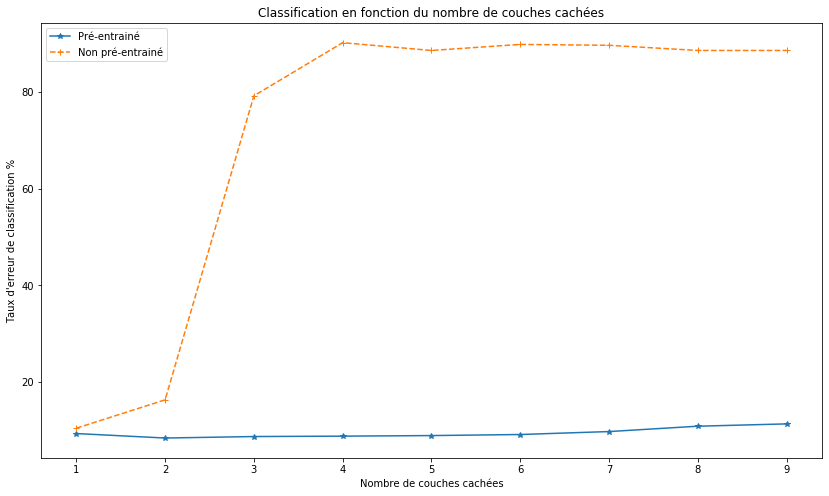

In [30]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
result1 = [9071,9164,9133,9125,9113,9091,9030,8919,8871]
result2 = [8960,8373,2075,974,1135,1010,1028,1135,1135]
y1 = 100*(1-(1/10000)*np.array(result1))
y2 = 100*(1-(1/10000)*np.array(result2))
plt.figure(1, figsize=(14,8))
plt.title("Classification en fonction du nombre de couches cachées")
plt.xlabel("Nombre de couches cachées")
plt.ylabel("Taux d'erreur de classification %")
plt.plot(x, y1, "*-" ,label="Pré-entrainé")
plt.plot(x, y2,"+--", label="Non pré-entrainé")
plt.legend()
plt.savefig('a.png')

## Classification en fonction du nombre de neuronnes sur les 2 couches cachées

#### _Pré-entrainé (éviter d'exécuter si on n'a pas de temps)_

In [ ]:
from datetime import datetime
start_time = datetime.now()
a = [10, 20, 50, 100, 150, 200, 250, 300, 350]
result3 = []
for i in a:
    couches = [784,10]
    couches.insert(1, i)
    couches.insert(1, i)
    pre_train_dnn = DNN(couches,batch_size = 100,lr = 0.1, pre_train = True)
    pre_train_dnn = pre_train_dnn.train_DNN(X_train.T[:10000].T,train_y.T[:10000].T,test,test_y,20)
    result3.append(pre_train_dnn.test_DNN(test,test_y))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
result3

#### _Non Pré-entrainé_

In [37]:
from datetime import datetime
start_time = datetime.now()
a = [10, 20, 50, 100, 150, 200, 250, 300, 350]
result4 = []
for i in a:
    couches = [784,10]
    couches.insert(1, i)
    couches.insert(1, i)
    no_pre_train_dnn = DNN(couches,batch_size = 100,lr = 0.1, pre_train = False)
    no_pre_train_dnn = no_pre_train_dnn.train_DNN(X_train.T[:10000].T,train_y.T[:10000].T,test,test_y,20)
    result4.append(no_pre_train_dnn.test_DNN(test,test_y))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
result4

Phase d'Entrainement !
cross_entropy : -11981.222605136285
classification rate : 6003 / 10000
Phase d'Entrainement !
cross_entropy : -7268.126962702807
classification rate : 8027 / 10000
Phase d'Entrainement !
cross_entropy : -4172.889751299981
classification rate : 8718 / 10000
Phase d'Entrainement !
cross_entropy : -3199.9866574147
classification rate : 8964 / 10000
Phase d'Entrainement !
cross_entropy : -2984.979112231631
classification rate : 9036 / 10000
Phase d'Entrainement !
cross_entropy : -2862.0235589866843
classification rate : 9054 / 10000
Phase d'Entrainement !
cross_entropy : -2819.1479199866403
classification rate : 9065 / 10000
Phase d'Entrainement !
cross_entropy : -2684.846292685127
classification rate : 9070 / 10000
Phase d'Entrainement !
cross_entropy : -2637.725907152404
classification rate : 9087 / 10000
Duration: 0:02:20.268412


[6003, 8027, 8718, 8964, 9036, 9054, 9065, 9070, 9087]

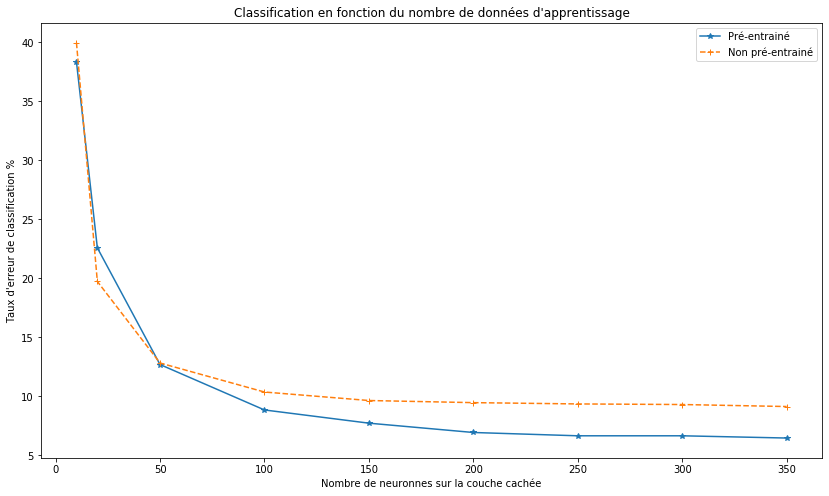

In [28]:
x = [10, 20, 50, 100, 150, 200, 250, 300, 350]
result5 = [6166, 7742, 8731, 9116, 9228, 9307, 9335, 9335, 9354]
result6 = [6003, 8027, 8718, 8964, 9036, 9054, 9065, 9070, 9087]
y1 = 100*(1-(1/10000)*np.array(result5))
y2 = 100*(1-(1/10000)*np.array(result6))
plt.figure(1, figsize=(14,8))
plt.title("Classification en fonction du nombre de données d'apprentissage")
plt.xlabel("Nombre de neuronnes sur la couche cachée")
plt.ylabel("Taux d'erreur de classification %")
plt.plot(x, y1, "*-" ,label="Pré-entrainé")
plt.plot(x, y2,"+--", label="Non pré-entrainé")
plt.legend()

## Classification en fonction du nombre de données d'apprentissage

#### _Pré-entrainé (éviter d'exécuter si on n'a pas de temps)_

In [ ]:
from datetime import datetime
start_time = datetime.now()
a = [3000, 5000, 7500, 10000, 20000, 30000, 40000, 50000, 60000]
result5 = []
for i in a:
    pre_train_dnn = DNN([784,100, 100,10],batch_size = 100,lr = 0.1, pre_train = True)
    pre_train_dnn = pre_train_dnn.train_DNN(X_train.T[:i].T,train_y.T[:i].T,test,test_y,20)
    result5.append(pre_train_dnn.test_DNN(test,test_y))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
result5

#### _Non Pré-entrainé_

In [36]:
from datetime import datetime
start_time = datetime.now()
a = [3000, 5000, 7500, 10000, 20000, 30000, 40000, 50000, 60000]
result6 = []
for i in a:
    no_pre_train_dnn = DNN([784,100, 100,10],batch_size = 100,lr = 0.1, pre_train = False)
    no_pre_train_dnn = no_pre_train_dnn.train_DNN(X_train.T[:i].T,train_y.T[:i].T,test,test_y,20)
    result6.append(no_pre_train_dnn.test_DNN(test,test_y))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
result6

Phase d'Entrainement !
cross_entropy : -2298.097893914166
classification rate : 7980 / 10000
Phase d'Entrainement !
cross_entropy : -2378.901593147745
classification rate : 8589 / 10000
Phase d'Entrainement !
cross_entropy : -2709.44613717467
classification rate : 8848 / 10000
Phase d'Entrainement !
cross_entropy : -3268.584641404925
classification rate : 8949 / 10000
Phase d'Entrainement !
cross_entropy : -4916.477462162964
classification rate : 9201 / 10000
Phase d'Entrainement !
cross_entropy : -6105.203904639382
classification rate : 9345 / 10000
Phase d'Entrainement !
cross_entropy : -6822.074380423997
classification rate : 9454 / 10000
Phase d'Entrainement !
cross_entropy : -7610.338654119127
classification rate : 9509 / 10000
Phase d'Entrainement !
cross_entropy : -8209.592060447208
classification rate : 9543 / 10000
Duration: 0:03:33.536300


[7980, 8589, 8848, 8949, 9201, 9345, 9454, 9509, 9543]

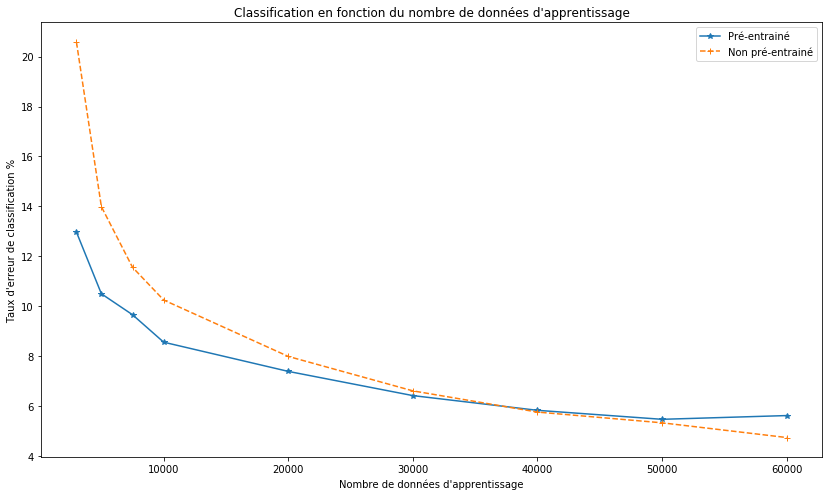

In [27]:
x = [3000, 5000, 7500, 10000, 20000, 30000, 40000, 50000, 60000]
result5 = [8703, 8950, 9034, 9144, 9261, 9358, 9417, 9453, 9438]
result6 = [7942, 8601, 8844, 8975, 9201, 9339, 9424, 9467, 9526]
y1 = 100*(1-(1/10000)*np.array(result5))
y2 = 100*(1-(1/10000)*np.array(result6))
plt.figure(1, figsize=(14,8))
plt.title("Classification en fonction du nombre de données d'apprentissage")
plt.xlabel("Nombre de données d'apprentissage")
plt.ylabel("Taux d'erreur de classification %")
plt.plot(x, y1, "*-" ,label="Pré-entrainé")
plt.plot(x, y2,"+--", label="Non pré-entrainé")
plt.legend()

### Exécution du DNN avec les paramètres optimaux (mais No Pre Train pour gagner du temps)

In [31]:
from datetime import datetime
start_time = datetime.now()
couches = [784,400,400,10]
no_pre_train_dnn = DNN(couches,batch_size = 100,lr = 0.1, pre_train = False)
no_pre_train_dnn = no_pre_train_dnn.train_DNN(X_train.T[:60000].T,train_y.T[:60000].T,test,test_y,50)
print(no_pre_train_dnn.test_DNN(test,test_y))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Phase d'Entrainement !
epoch n° 1 / 50 | cross_entropy : -25889.525127961177
epoch n° 2 / 50 | cross_entropy : -20610.480762009982
epoch n° 3 / 50 | cross_entropy : -19003.41290699917
epoch n° 4 / 50 | cross_entropy : -17115.429518664863
epoch n° 5 / 50 | cross_entropy : -16118.916728264869
epoch n° 6 / 50 | cross_entropy : -15165.713522101463
epoch n° 7 / 50 | cross_entropy : -14294.975647971496
epoch n° 8 / 50 | cross_entropy : -13760.447695719959
epoch n° 9 / 50 | cross_entropy : -12749.488775871518
epoch n° 10 / 50 | cross_entropy : -12651.017839983426
epoch n° 11 / 50 | cross_entropy : -11650.393695760871
epoch n° 12 / 50 | cross_entropy : -11050.888498777098
epoch n° 13 / 50 | cross_entropy : -11116.478173106714
epoch n° 14 / 50 | cross_entropy : -9974.74990150937
epoch n° 15 / 50 | cross_entropy : -9501.84516040847
epoch n° 16 / 50 | cross_entropy : -8991.776687343508
epoch n° 17 / 50 | cross_entropy : -8943.015848315054
epoch n° 18 / 50 | cross_entropy : -8517.319689278756
epoc

## Taux définitif : 2.84%

# FIN